In [1]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [2]:
from torch import empty, Tensor

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

## Testing data generation

In [4]:
train_input, train_target, test_input, test_target = load_dataset(1000, standardize=True)

NameError: name 'load_dataset' is not defined

<AxesSubplot:xlabel='x', ylabel='y'>

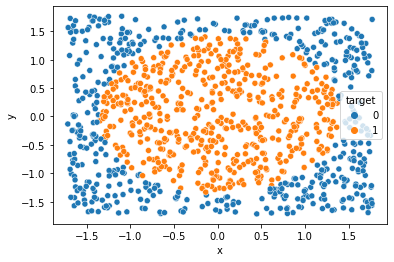

In [12]:
df = pd.DataFrame(train_input.tolist())

df['target'] = train_target.tolist()
df.columns = ['x', 'y', 'target']

sns.scatterplot(data=df, x='x', y='y', hue='target')

## Testing loss

In [12]:
from torch import tensor

In [27]:
from src.module import Module


class MSELoss(Module):
    def __init__(self):
        super().__init__()

    def forward(self, prediction, target):
        
        print(prediction)
        print(target)
        
        self.prediction = prediction.view(-1)
        self.target = target
        return (prediction - target).pow(2).mean()

    def backward(self):
        return 2 * (self.prediction - self.target) / (self.prediction.size(0))

In [28]:
prediction = tensor([[-0.4433],
        [-0.2356],
        [-0.2109],
        [-0.1666],
        [-0.3752],
        [-0.0956],
        [-0.3019],
        [-0.0784],
        [-0.2483],
        [-0.0612]])
target = tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1])

In [29]:
criterion = MSELoss()

In [30]:
criterion(prediction, target)

tensor([[-0.4433],
        [-0.2356],
        [-0.2109],
        [-0.1666],
        [-0.3752],
        [-0.0956],
        [-0.3019],
        [-0.0784],
        [-0.2483],
        [-0.0612]])
tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1])


tensor(1.0741)

In [31]:
criterion.backward()

tensor([-0.0887, -0.2471, -0.2422, -0.2333, -0.0750, -0.2191, -0.0604, -0.2157,
        -0.2497, -0.2122])

# Evaluate Metrics

In [34]:
import matplotlib as mpl

SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 16

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_SIZE
mpl.rcParams['axes.titlesize'] = SMALL_SIZE
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE
mpl.rcParams['legend.fontsize'] = SMALL_SIZE
mpl.rcParams['figure.titlesize'] = LARGE_SIZE

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.facecolor'] = '#F5F5F5'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = [6, 3.259]

In [7]:
df = pd.read_json('../results/metrics.json')

df['model'] = df['optimizer'] + ' ' + df['criterion'] 

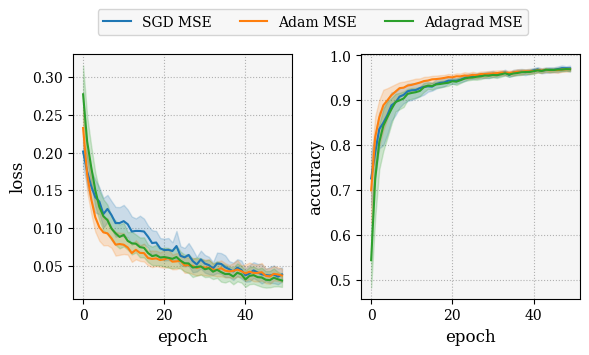

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3.25), dpi=100)

g = sns.lineplot(data=df, x='epoch', y='loss', hue='model', ax=axes[0], legend='brief')
sns.lineplot(data=df, x='epoch', y='accuracy', hue='model', ax=axes[1], legend=False)

h,l = g.axes.get_legend_handles_labels()
g.axes.legend_.remove()
lgd = fig.legend(h,l, ncol=4, bbox_to_anchor=(0.9, 1.10))

plt.tight_layout()
fig.savefig('../figures/training.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=fig.dpi)
plt.show()

# What does our model actually show?

In [6]:
import flame
from flame import nn

from train import train
from utils import load_dataset
from metrics import evaluate_accuracy

In [24]:
train_input, train_target, \
        test_input, test_target, mu, sigma = load_dataset(1000, standardize=True)

In [25]:
model = nn.Sequential([
    nn.Linear(2, 25), nn.ReLU(),
    nn.Linear(25, 25), nn.Dropout(p=0.3), nn.ReLU(),
    nn.Linear(25, 25), nn.ReLU(),
    nn.Linear(25, 1)])

model.init_weights()

model.train()

train(model, train_input, train_target, verbose=1)

Epoch 05 	Loss 0.222 	Acc. 72.600
Epoch 10 	Loss 0.148 	Acc. 89.000
Epoch 15 	Loss 0.135 	Acc. 91.400
Epoch 20 	Loss 0.097 	Acc. 93.400
Epoch 25 	Loss 0.093 	Acc. 93.900
Epoch 30 	Loss 0.077 	Acc. 95.000
Epoch 35 	Loss 0.077 	Acc. 95.900
Epoch 40 	Loss 0.076 	Acc. 94.900
Epoch 45 	Loss 0.068 	Acc. 96.100
Epoch 50 	Loss 0.064 	Acc. 96.700


In [26]:
evaluate_accuracy(model, test_input, test_target).item()

0.9629999995231628

In [27]:
prediction = model(test_input).flatten()

df = pd.DataFrame(test_input.mul_(sigma).add_(mu).tolist())

df['prediction'] = ((prediction > .2).float() + (prediction > .8).float()).tolist()
df['prediction_real'] = prediction.tolist()
df.columns = ['x', 'y', 'prediction', 'prediction_real']

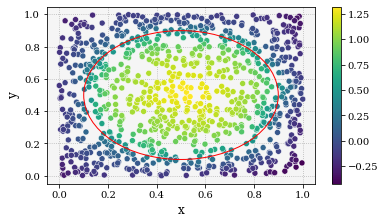

In [32]:
import math

ax = sns.scatterplot(data=df, x='x', y='y', hue='prediction_real', palette='viridis')

norm = plt.Normalize(df['prediction_real'].min(), df['prediction_real'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

circle = plt.Circle((0.5, 0.5), 1 / math.sqrt(2 * math.pi), color='r', fill=False)

ax.add_patch(circle)

plt.savefig('../figures/test-distribution.png')

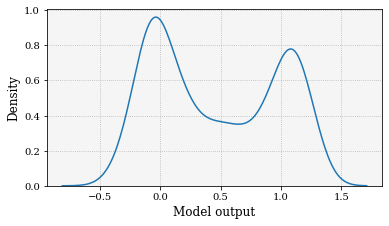

In [40]:
ax = sns.kdeplot(data=df, x='prediction_real', )

ax.set_xlabel('Model output')

plt.savefig('../figures/output-distribution.png')

In [27]:
prediction = model(test_input).flatten()

<AxesSubplot:>

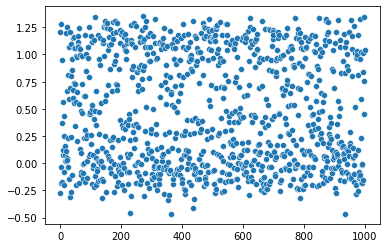

In [28]:
sns.scatterplot(x=list(range(prediction.size(0))), y=prediction.tolist())